C:\Users\gabriel\AppData\Local\Temp\ipykernel_17208\3628106000.py:29: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  gaussian_points = np.random.multivariate_normal(mean, cov, points_per_gaussian)


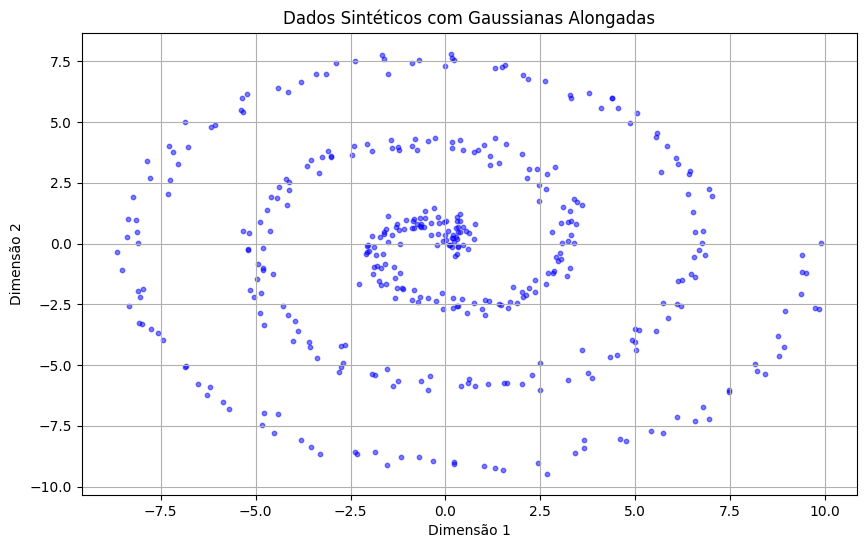

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.interpolate import interp1d

# Configurações das gaussianas
np.random.seed(42)  # Para reprodutibilidade
num_gaussians = 5
points_per_gaussian = 500

# Parâmetros de cada gaussiana (média e covariância)
means = [
    [0, 0],
    [5, 3],
    [10, 2],
    [15, 1],
]

covariances = [
    [[2, 3], [0, 0.5]],
    [[5,0], [0.2, 0.5]],
    [[3, -2], [0, 0]],
    [[1.2, 0.6], [0.6, 1]],
]

# Gerar os dados
data = []
for mean, cov in zip(means, covariances):
    gaussian_points = np.random.multivariate_normal(mean, cov, points_per_gaussian)
    data.append(gaussian_points)

data = np.vstack(data)

# Adicionar ruído
noise = np.random.normal(0, 0.2, data.shape)
data_with_noise = data + noise


def gmm_principal_curve(data, n_components=5):
    """
    Approximate a principal curve using a Gaussian Mixture Model.
    
    Parameters:
    - data: np.ndarray, shape (n_samples, n_features)
      Input data.
    - n_components: int
      Number of Gaussian components in the GMM.
    - n_points: int
      Number of points to sample on the principal curve.

    Returns:
    - curve: np.ndarray, shape (n_points, n_features)
      The computed principal curve.
    """
    # Fit GMM to the data
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(data)

    # Extract means of the GMM components
    means = gmm.means_
    covariances = gmm.covariances_
        
    # Sort means along a principal axis (e.g., first component)
    sort_indices = np.argsort(means[:, 0])
    means_sorted = means[sort_indices]
    covariances_sorted = covariances[sort_indices]
    
    pcs_ortogonal = []
    curve = []
    for i, mean in enumerate(means_sorted):
        # Compute PCA on the covariance matrix
        eigvals, eigvecs = np.linalg.eigh(covariances_sorted[i])
        
        # Take the second principal component
        std_dev0 = np.sqrt(eigvals[0]) 
        direction0 = eigvecs[:, 0]    
        std_dev1 = np.sqrt(eigvals[1]) 
        direction1 = eigvecs[:, 1]    
        
        # Scale the direction for visualization (2 * sqrt(2) * std_dev)
        scaled_direction0 = np.sqrt(2) * std_dev0 * direction0
        scaled_direction1 = std_dev1 * direction1
        
        # Save ellipse data
        pcs_ortogonal.append({
            'center': mean,
            'direction': direction0,
            'scaled_direction': scaled_direction0
        })
        curve.append({
            'center': mean,
            'direction': direction1,
            'scaled_direction': scaled_direction1
        })
    
    return curve, pcs_ortogonal
K = 20
import pandas as pd 
file_path = '../data/spiral_data.csv'  # Update the path if necessary
spiral_data = pd.read_csv(file_path)

# Extract x and y coordinates
x_data = spiral_data['x']
y_data = spiral_data['y']
data_with_noise = np.column_stack((x_data, y_data))
curve, ortogonal_components = gmm_principal_curve(data_with_noise, K)

validation_data_wrong = np.array([[10, 1]]) 
validation_data_right = np.array([[4, 1.7]]) 
    
# Plotar os dados
plt.figure(figsize=(10, 6))
plt.scatter(data_with_noise[:, 0], data_with_noise[:, 1], s=10, alpha=0.5, c='blue')
plt.title("Dados Sintéticos com Gaussianas Alongadas")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.grid(True)

points_shuffled = np.zeros((2*len(curve), 2))
for i, seg in enumerate(curve):
    center_seg = seg['center']
    scaled_direction_seg = seg['scaled_direction']
    points_shuffled[2*i] = np.array([center_seg + scaled_direction_seg])
    points_shuffled[2*i+1] = np.array([center_seg - scaled_direction_seg])


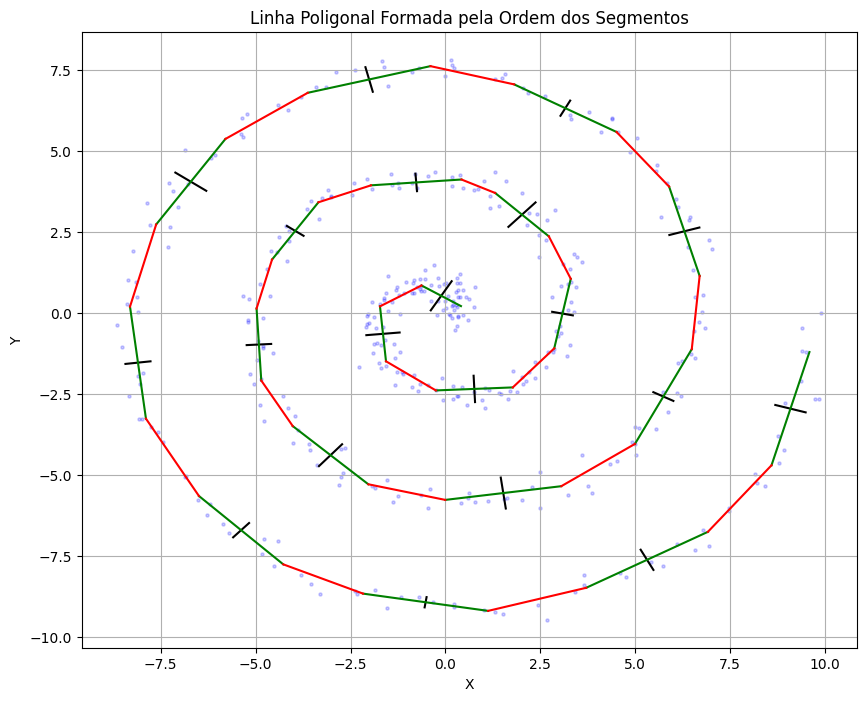

In [52]:
from scipy.spatial.distance import cdist

'''
Ordena Segmentos e também a componente principal ortogonal  
'''
segments = points_shuffled.reshape(len(points_shuffled) // 2, 2, 2)
# Lista para armazenar a ordem dos segmentos
ordered_segments = []

# Usar o primeiro segmento como ponto inicial
current_segment = segments[0]
ordered_segments.append(current_segment)
ordered_pcs = [ortogonal_components[0]]
current_start, current_end = current_segment

# Criar uma lista dos segmentos restantes
remaining_segments = list(segments[1:])
remaining_pcs = list(ortogonal_components[1:])

plt.figure(figsize=(10, 8))

while remaining_segments:
    # Criar uma lista com todos os extremos dos segmentos restantes
    candidates = []
    for seg in remaining_segments:
        candidates.extend(seg)
    candidates = np.array(candidates)
    
    # Calcular a menor distância entre o ponto final do segmento atual e os candidatos
    distances_end = cdist([current_end], candidates)
    distances_start = cdist([current_start], candidates)
    min_idx_end = np.argmin(distances_end)
    min_dist_end = np.min(distances_end)
    min_idx_start = np.argmin(distances_start)
    min_dist_start = np.min(distances_start)
    
    if min_dist_start > min_dist_end:  
        next_segment_idx = min_idx_end // 2
        next_segment = remaining_segments[next_segment_idx]
        ordered_pcs.append(remaining_pcs[next_segment_idx])
        if min_idx_end % 2 == 0:
            current_end = next_segment[1] 
            ordered_segments.append(next_segment)
        else:
            current_end = next_segment[0] 
            ordered_segments.append([next_segment[1], next_segment[0]])
              
    else:
        next_segment_idx = min_idx_start // 2
        next_segment = remaining_segments[next_segment_idx]
        ordered_pcs.insert(0, remaining_pcs[next_segment_idx])
        if min_idx_start % 2 == 0:
            current_start = next_segment[1] 
            ordered_segments.insert(0, [next_segment[1], next_segment[0]])
        else:
            current_start = next_segment[0] 
            ordered_segments.insert(0, next_segment)
        
    # Remover o segmento já utilizado
    del remaining_segments[next_segment_idx]
    del remaining_pcs[next_segment_idx]

ordered_segments = np.array(ordered_segments)

def calc_ort_line(segment_obj):
    return np.array([
        segment_obj['center'] + segment_obj['scaled_direction'],
        segment_obj['center'] - segment_obj['scaled_direction']
    ])
for i, segment in enumerate(ordered_segments):
    current_ortogonal_pc = calc_ort_line(ordered_pcs[i])                 
    plt.plot(current_ortogonal_pc[:,0], current_ortogonal_pc[:,1], linestyle='-', color='black')
    plt.plot(segment[:,0], segment[:,1], linestyle='-', color='g')
    if (i>=1):
        # Plot connection segment and its pc as an average of the neighbour segments
        plt.plot([segment[0][0], ordered_segments[i-1][1][0]], [segment[0][1], ordered_segments[i-1][1][1]], linestyle='-', color='r')
        prev_ortogonal_pc = calc_ort_line(ordered_pcs[i - 1])

'''
Plot data:
'''
plt.scatter(data_with_noise[:, 0], data_with_noise[:, 1], s=20, alpha=0.2, c='blue', marker='.')

plt.title('Linha Poligonal Formada pela Ordem dos Segmentos')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

[[-0.85295162  0.52198998]
 [ 0.09305659 -0.99566082]
 [ 0.9989478   0.0458617 ]
 [ 0.19870297  0.98005976]
 [-0.72617008  0.6875151 ]
 [-0.9971711  -0.07516514]
 [-0.56872378 -0.82252858]
 [ 0.05559977 -0.99845314]
 [ 0.74240408 -0.66995238]
 [ 0.99055691  0.13710218]
 [ 0.45554805  0.89021119]
 [-0.27997434  0.96000748]
 [-0.87818605  0.47831921]
 [-0.96908351 -0.24673294]
 [-0.56858001 -0.82262797]
 [ 0.1204806  -0.99271568]
 [ 0.72495587 -0.68879532]
 [ 0.98718053 -0.15960766]
 [ 0.88032983  0.47436208]
 [ 0.27473429  0.96152019]]
20


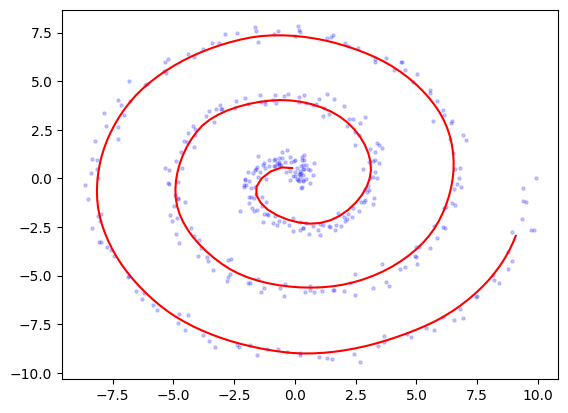

In [391]:
tangents_segs = np.zeros((len(curve_segs) // 2, 2))
curve_segs = np.asarray(curve_points)
# for i, segment in enumerate(curve_segs):
#     if i < len(curve_segs) -1:
#         plt.plot([segment[0], curve_segs[i+1][0]], [segment[1], curve_segs[i+1][1]], linestyle='-', color='g' if i % 2 == 0 else 'red', label='Curva', alpha=0.2)
for i, seg_point in enumerate(curve_segs):
    if (i % 2 == 0) and (i < len(curve_segs) - 1):
        tang = curve_segs[i+1] - ordered_centroids[i//2]
        tangents_segs[i//2] = tang / np.linalg.norm(tang) 
print(tangents_segs)

resolution = 0.5
# Interpolate with different tangent lengths, but equal direction.
scale = 1
tangents = np.dot(np.asarray(tangents_segs), scale*np.eye(2))
print(len(tangents))
samples = sampleCubicSplinesWithDerivative(ordered_centroids, tangents, resolution)
M = 200
t = np.linspace(0, len(samples[:,0]), M)
x = np.interp(t, np.arange(len(samples[:,0])), samples[:,0])
y = np.interp(t, np.arange(len(samples[:,1])), samples[:,1])

plt.scatter(data_with_noise[:, 0], data_with_noise[:, 1], s=20, alpha=0.2, c='blue', marker='.')
plt.plot(x, y, c='r')
